In [ ]:
import nltk    
import random
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import brown
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding,LSTM
from keras.preprocessing.text import Tokenizer
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras import layers

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulrazzakramadan","key":"03291e9a972e8ab12652f47960628fc1"}'}

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle competitions download -c shai-training-2023-a-level-2

 66% 17.0M/25.7M [00:00<00:00, 65.8MB/s]
100% 25.7M/25.7M [00:00<00:00, 81.8MB/s]


In [ ]:
! unzip shai-training-2023-a-level-2

Archive:  shai-training-2023-a-level-2.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: Valid.csv               
  inflating: sample_submission.csv   


In [ ]:
df =pd.read_csv("/content/Train.csv")

In [ ]:
print(df.head)

<bound method NDFrame.head of                                                     text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[40000 rows x 2 columns]>


In [ ]:
print("Null Values: ")
print(df.isna().sum())

Null Values: 
text     0
label    0
dtype: int64


In [ ]:
#Removing Duplication
no_of_duplicates=df.duplicated().sum()
print ('No. of Dublicates:' ,no_of_duplicates)

if(no_of_duplicates >0):
  df.drop_duplicates(inplace=True)
  print ('Dublicates Removed...')

No. of Dublicates: 277
Dublicates Removed...


In [ ]:
positive_reviews = []
negative_reviews = []

In [ ]:
count = 0
for i in df["text"]:
  if df["label"].iloc[count] == 0:
    negative_reviews.append(i)
  else:
    positive_reviews.append(i)
  count = count + 1

In [ ]:
print('Number of positive reviews: ', len(positive_reviews))
print('Number of negative reviews: ', len(negative_reviews))

Number of positive reviews:  19908
Number of negative reviews:  19815


In [ ]:
print('Positive Example: ' + positive_reviews[random.randint(0,19908)])
print('\nNegative Example: ' + negative_reviews[random.randint(0,19908)])

Positive Example: Starfucker (which reads Starstruck on my box) was the most amazing movie I have ever seen. I thought that it was one of the best movies I have ever seen. So why not a 10? Nothing is perfect. Jamie Kennedy proves why he is one of my favorite actors in this very interesting look at a darker side of Hollywood. I have forced a few others to watch the movie and they all agreed that it was an outstanding flick.

Negative Example: Scanning through the comments, there doesn't appear to be a lot of love for this movie, and it's not very hard to see why, it's rubbish.<br /><br />Now, I will start by saying that the finished product was hurt, in any number of ways, by the death of Donald Pleasance (Dr Loomis) in post production. This required a re-jigging of the film's conclusion with Loomis buying the farm and took away what was supposed to be a double twist at the end with Micheal swapping places with mysterious "Man in black" and I do not mean Johnny Cash.<br /><br />Now to t

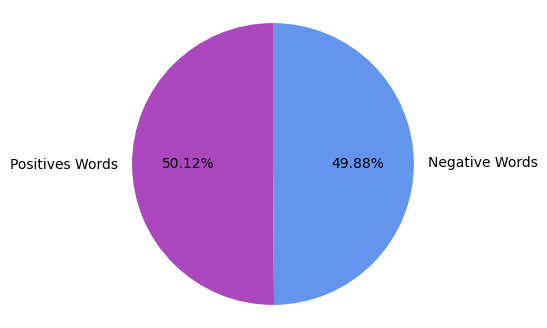

In [ ]:
fig = plt.figure(figsize = (4, 4))
sizes = [len(positive_reviews), len(negative_reviews)]
labels = 'Positives Words', 'Negative Words'
colors=['#AB47BC','#6495ED']
plt.pie(sizes, labels=labels, autopct='%.2f%%',colors=colors, startangle=90)
plt.axis('equal')
plt.show()

## **Cleaning the Data**

In [ ]:
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)

nltk.download('stopwords')
nltk.download('brown')
nltk.download('punkt')
stop_words =  stopwords.words('english')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(re.compile('<.*?>'), '', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    #Remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [ ]:
df["Reviews"] = df["text"].apply(text_cleaning)

In [ ]:
X = df["Reviews"]
y = df.label.values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1000, stratify=y)



```
# This is formatted as code
```

# **Naïve Bayes Classifier**

In [ ]:
Classifier = Pipeline(steps=[('pre_processing',TfidfVectorizer(lowercase = True)),('naive_bayes',MultinomialNB())])
Classifier.fit(X_train, y_train)

Pipeline(steps=[('pre_processing', TfidfVectorizer()),
                ('naive_bayes', MultinomialNB())])

In [ ]:
y_Pred = Classifier.predict(X_test)
Accuracy = accuracy_score(y_test, y_Pred)
print("Accuracy Score: {}".format(Accuracy))

Accuracy Score: 0.8635619886721209


# **RNN**

In [ ]:
np.random.seed(42)
max_train = len(max(df["Reviews"], key=len))

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 
print(X_train[1])

[2, 244, 153, 3, 2, 6, 96, 263, 10, 2, 48, 45, 1599, 1707, 33, 429, 668, 493, 21, 5, 10, 3, 3770, 176, 493, 325, 323, 3203, 4840, 879, 437, 3863, 323, 26, 325, 1, 1, 3347, 26, 12, 864, 823, 1834, 65, 386, 364, 2189, 918, 2892, 369, 388, 638, 28, 860, 2862, 4190, 2283, 218, 491, 105, 1, 1, 348, 2, 1219, 656, 1348, 2, 201, 3, 8, 339, 2, 768, 890, 27, 493, 823, 30, 32, 492, 96, 155, 31, 73, 599, 332, 87, 1043, 367, 1154, 3654, 157, 35]


In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train.shape
# Preprocess data
X_train = pad_sequences(X_train, maxlen=max_train)
X_test = pad_sequences(X_test, maxlen=max_train)
num_classes = np.max(y_train) + 1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


In [ ]:
# Define RNN model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=max_train))
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(100))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# Train model
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

# Evaluate model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **LSTM**

In [ ]:

# Define LSTM model
model = Sequential()
model.add(Embedding(10000, 32, input_length=max_train))
model.add(LSTM(100))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

# Evaluate model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
Y = np.argmax(y_test, axis=1)
accuracy_score(Y, predict)

### **Confusin Matrix**

In [ ]:
Y_test = np.argmax(y_test, axis=1)

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(Y_test, y_Pred)
plt.figure(figsize = (7,6))
sns.heatmap(cm, annot=True, cmap='Greens')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(Y_test, y_Pred)
print(report)

## **Submission**

In [ ]:
#Preprocess the test data
Test_Data = pd.read_csv("/content/Test.csv")
Test_Data["Reviews"] = Test_Data["text"].apply(text_cleaning)

In [ ]:
Label = tokenizer.texts_to_sequences(Test_Data["Reviews"])
Label = pad_sequences(Label, maxlen=max_train)

In [ ]:
Test_Predection = Classifier.predict(Test_Data["Reviews"])

In [ ]:
Test_Predection.shape

In [ ]:
Test_Predection

In [ ]:
ID = [i for i in range(0,5000)]
Movies = pd.DataFrame(ID, columns = ['id'])
Movies["label"] = Test_Predection

In [ ]:
Movies.to_csv('Submission.csv', index=False)

# **Deployment**

In [ ]:
!pip install fastapi
!pip install uvicorn

# text preprocessing modules
from string import punctuation
# text preprocessing modules
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re  # regular expression
import os
from os.path import dirname, join, realpath
import joblib
import uvicorn
from fastapi import FastAPI 

app = FastAPI(
    title="Sentiment Model API",
    description="A simple API that use NLP model to predict the sentiment of the movie's reviews",
    version="0.1",
)

# cleaning the data
def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(re.compile('<.*?>'), '', text)
    text = re.sub(r"http\S+", " link ", text)
    text = re.sub(r"\b\d+(?:\.\d+)?\s+", "", text)  # remove numbers
    
    # Remove punctuation from text
    text = "".join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        # load stopwords
        stop_words = stopwords.words("english")
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
        
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
        
    # Return a list of words
    return text

@app.get("/predict-review")
def predict_sentiment(review: str):
    """
    A simple function that receive a review content and predict the sentiment of the content.
    :param review:
    :return: prediction, probabilities
    """
    # clean the review
    cleaned_review = text_cleaning(review)
    
    # perform prediction
    prediction = Classifier.predict([cleaned_review])
    output = int(prediction[0])
    probas = Classifier.predict_proba([cleaned_review])
    output_probability = "{:.2f}".format(float(probas[:, output]))
    
    # output dictionary
    sentiments = {0: "Negative", 1: "Positive"}
    
    # show results
    result = {"prediction": sentiments[output], "Probability": output_probability}
    return result

In [ ]:
!uvicorn api:app --reload